# Visualization

In this notebook we try to visualize the data, analyse it and observe the outputs of the models. 

## Dataset

In [2]:
import os

# Set the root to the root of the repo
repo_root = os.path.abspath("C:/Users/leobu/Documents/MVA/S1/RecVis/recvis24_a3")
os.chdir(repo_root)
print(f"Current working directory: {os.getcwd()}")

Current working directory: C:\Users\leobu\Documents\MVA\S1\RecVis\recvis24_a3


In [3]:
import torch
from torchvision import datasets
from data import data_transforms, data_transforms_resnet, data_transforms_sketch
import matplotlib.pyplot as plt
from torchvision.utils import make_grid


## Without Pre-processing

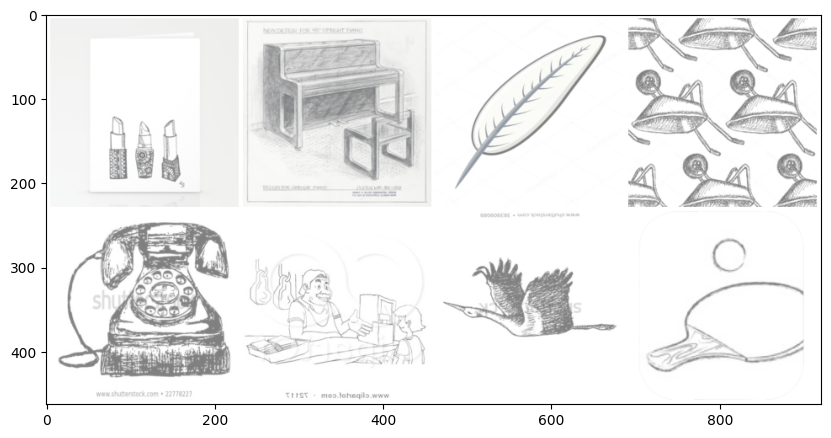

In [194]:
from torchvision import transforms
import yaml

# Define a function to load configuration parameters
def load_config(config_path):
    with open(config_path, "r") as file:
        config_params = yaml.safe_load(file)
    return config_params


data_transforms_vanilla = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),

])

# Load parameters from config file
config = 'configs/config_test.yaml'
config_params = load_config(config)

# Data initialization and loading (make sure to set `num_workers` to 0 to avoid multiprocessing issues on Windows)
train_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(config_params['data'], transform=data_transforms_vanilla),
    batch_size=config_params['batch_size'],
    shuffle=True,
    num_workers=0  # Set num_workers to 0 to avoid multiprocessing issues
)

import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

# Function to show an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    npimg = np.clip(npimg, 0, 1)  # Clip the values to be in the range [0, 1]
    plt.figure(figsize=(10, 10))  # Set the figure size
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get a batch of training data
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
imshow(make_grid(images, nrow=4, padding=5, pad_value=1))

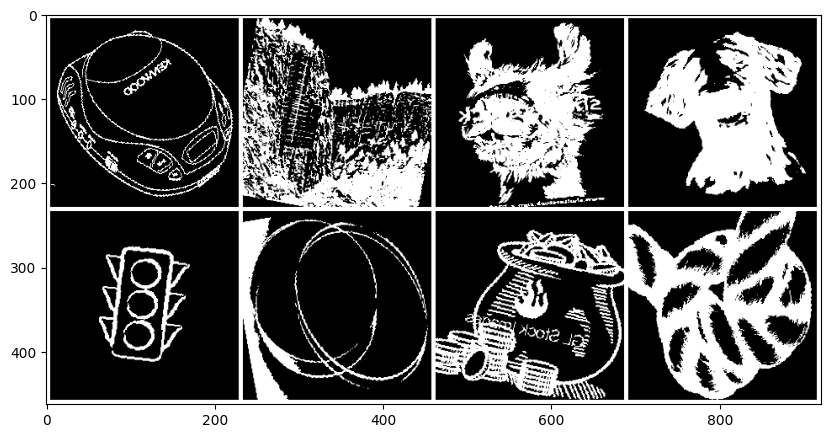

In [341]:
from torchvision import transforms
import yaml

# Define a function to load configuration parameters
def load_config(config_path):
    with open(config_path, "r") as file:
        config_params = yaml.safe_load(file)
    return config_params


class InvertColorsIfNeeded:
    def __call__(self, img):
        # Convert the image to grayscale to calculate mean intensity
        grayscale_img = img.convert("L")
        img_np = np.array(grayscale_img)

        # Calculate the mean intensity
        mean_intensity = img_np.mean()
        # If the image is mostly dark, invert the colors
        if mean_intensity > 128:
            return ImageOps.invert(img)
        return img
    
class AdaptiveBinarize:
    def __call__(self, img):
        # Calculate the mean pixel value of the grayscale image
        mean_intensity = img.mean()
        
        # Adjust threshold relative to mean intensity to avoid an all-black image
        threshold = min(max(mean_intensity, 0.1), 0.9)  # Threshold between 0.1 and 0.9 to avoid extreme values
        
        # Apply thresholding
        return (img > threshold).float()


# Replace lambda for repeating channels with a proper class
class RepeatChannels:
    def __init__(self, num_channels):
        self.num_channels = num_channels

    def __call__(self, img):
        return img.repeat(self.num_channels, 1, 1)

import torch
import torch.nn.functional as F
from PIL import Image
import numpy as np

class GaussianBlur:
    def __init__(self, kernel_size: int = 5, sigma: float = 1.0):
        self.kernel_size = kernel_size
        self.sigma = sigma

    def __call__(self, img):
        # Convert the PIL image to a torch tensor if it's not already
        if isinstance(img, Image.Image):
            img = transforms.ToTensor()(img)
        
        # Create Gaussian kernel
        channels, height, width = img.shape
        kernel = self._create_gaussian_kernel(self.kernel_size, self.sigma)

        # Apply the Gaussian filter to each channel separately
        img_filtered = []
        for c in range(channels):
            img_c = img[c].unsqueeze(0).unsqueeze(0)  # Add batch and channel dimension
            img_c_blurred = F.conv2d(img_c, kernel, padding=self.kernel_size // 2)
            img_filtered.append(img_c_blurred.squeeze())

        return torch.stack(img_filtered)

    def _create_gaussian_kernel(self, kernel_size: int, sigma: float):
        """Creates a 2D Gaussian kernel to be used for convolution."""
        ax = torch.arange(-kernel_size // 2 + 1., kernel_size // 2 + 1.)
        xx, yy = torch.meshgrid(ax, ax)
        kernel = torch.exp(-(xx**2 + yy**2) / (2. * sigma**2))
        kernel = kernel / kernel.sum()
        kernel = kernel.view(1, 1, kernel_size, kernel_size)
        return kernel


# Define data augmentation
data_augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.RandomResizedCrop(size=(224, 224), scale=(0.9, 1.0))  # Reduce zoom
])

data_transforms_sketch = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.Grayscale(num_output_channels=1),
        InvertColorsIfNeeded(),  # Invert colors to make background black and sketch white
        transforms.ToTensor(),
        AdaptiveBinarize(),  # Binarization with a specified threshold
        GaussianBlur(kernel_size=5, sigma=0.2),  # Apply Gaussian blur to smooth out the image
        RepeatChannels(num_channels=3),  # Duplicate grayscale channel to 3 channels
        data_augmentation,  # Apply data augmentation
        transforms.Normalize(mean=[0.485], std=[0.229]),  # Adjust mean and std for grayscale
   
    ]
)   
# Load parameters from config file
config = 'configs/config_test.yaml'
config_params = load_config(config)

# Data initialization and loading (make sure to set `num_workers` to 0 to avoid multiprocessing issues on Windows)
train_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(config_params['data'], transform=data_transforms_sketch),
    batch_size=config_params['batch_size'],
    shuffle=True,
    num_workers=0  # Set num_workers to 0 to avoid multiprocessing issues
)

import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

# Function to show an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    npimg = np.clip(npimg, 0, 1)  # Clip the values to be in the range [0, 1]
    plt.figure(figsize=(10, 10))  # Set the figure size
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get a batch of training data
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
imshow(make_grid(images, nrow=4, padding=5, pad_value=1))

In [ ]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

# Function to identify black images
def find_black_images(loader, save_path="black_images"):
    # Create a folder to save black images if it doesn't exist
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    # Iterate through the data loader
    for batch_idx, (images, labels) in enumerate(loader):
        for i, img in enumerate(images):
            # Check if the image is entirely black (all values are zero)
            if torch.sum(img) <0.01:
                print(f"Black image found in batch {batch_idx}, index {i}")
                
                # Save the black image for further inspection
                img_path = os.path.join(save_path, f"black_image_batch{batch_idx}_index{i}.png")
                plt.imsave(img_path, img.permute(1, 2, 0).numpy())
                
                # Alternatively, display the black image
                plt.imshow(img.permute(1, 2, 0).numpy(), cmap="gray")
                plt.title(f"Black Image - Batch {batch_idx}, Index {i}")
                plt.show()

# Load parameters from config file
config = 'configs/config_test.yaml'
config_params = load_config(config)

# Data initialization and loading (make sure to set `num_workers` to 0 to avoid multiprocessing issues on Windows)
train_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(config_params['data'], transform=data_transforms_sketch),
    batch_size=config_params['batch_size'],
    shuffle=True,
    num_workers=0  # Set num_workers to 0 to avoid multiprocessing issues
)

# Call the function to find black images
find_black_images(train_loader)


Black image found in batch 0, index 0


ValueError: Floating point image RGB values must be in the 0..1 range.

## Display outputs

C:\Users\leobu\AppData\Local\Temp\ipykernel_30272\4022214889.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=torch.devic

No existing model found. Initializing a new resnet50 model.


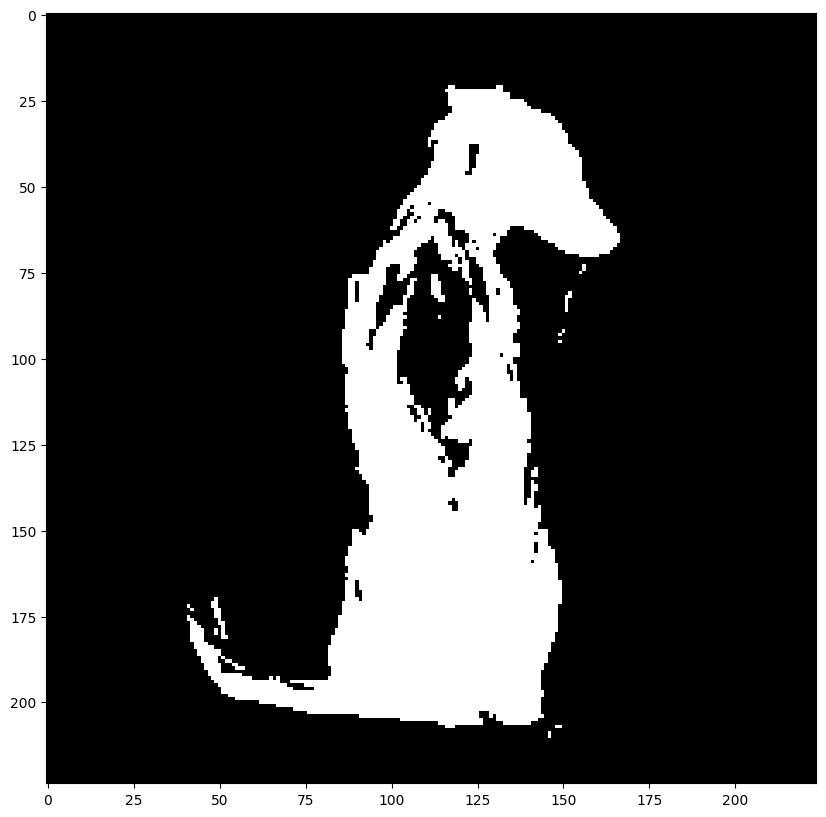

Predicted Label: 86


In [ ]:
# test_dir = config_params['data'] + "/test_images/mistery_category"
from model_factory import ModelFactory
# cuda
use_cuda = torch.cuda.is_available()

model_path = "experiment/resnet50/model_best_epoch_1_val_loss_0.0423.pth"
# load model and transform
state_dict = torch.load(model_path, map_location=torch.device('cpu'))
model, data_transforms, _, _ = ModelFactory("resnet50").get_all()
model.load_state_dict(state_dict)

# Predict on a train image
# Take an image from the batch
image = images[0].unsqueeze(0)

# Move the image to GPU if available
if use_cuda:
    image = image.cuda()
    model = model.cuda()

# Set the model to evaluation mode
model.eval()

# Perform the prediction
with torch.no_grad():
    output = model(image)
    _, predicted = torch.max(output, 1)

# Plot the image
imshow(image.cpu().squeeze())

# Print the predicted label
print(f'Predicted Label: {predicted.item()}')
